# Rating of a Plain Fin-Tube Counterflow Air Evaporator
---

**Importing libraries and notebook preparation**

In [1]:
import warnings
from hvac import Quantity
from hvac.fluids import HumidAir, Fluid, CoolPropWarning
from hvac.heat_exchanger.recuperator.fintube import PFT_CF_AE
from hvac.charts import PsychrometricChart
from hvac.air_conditioning import AirConditioningProcess

warnings.filterwarnings('ignore', category=CoolPropWarning)
Q_ = Quantity

## Refrigerant

In [2]:
R134a = Fluid('R134a')

## Evaporator Model

We'll use the model of a plain fin-tube, counter-flow air evaporator.

In [3]:
Evaporator = PFT_CF_AE  # Plain Fin-Tube Counter Flow Heat Exchanger

To create an instance of the evaporator model, we need to specify the width and height of the frontal area, the number of rows, the geometrical properties of the heat exchanger core, and the thermal conductivity of the fins. The dimensions of the frontal area have been determined in the preliminary calculations (see *ex01_prelim.ipynb*).

In [4]:
evp = Evaporator(
    W_fro=Q_(0.731, 'm'),         # width of frontal area
    H_fro=Q_(0.244, 'm'),         # height of frontal area
    N_rows=6,                     # number of rows: this can be modified until a solution is found
    S_trv=Q_(25.4, 'mm'),         # vertical distance between tubes
    S_lon=Q_(22.0, 'mm'),         # horizontal distance between tubes
    D_int=Q_(8.422, 'mm'),        # inner tube diameter
    D_ext=Q_(10.2, 'mm'),         # outer tube diameter
    t_fin=Q_(0.3302, 'mm'),       # fin thickness
    N_fin=1 / Q_(3.175, 'mm'),    # fin density
    k_fin=Q_(237, 'W / (m * K)')  # conductivity of fin material
)

## Evaporator Rating

On the evaporator model, we set the known operating conditions:
- the state of air entering the evaporator
- the mass flow rate of air through the evaporator
- the state of the liquid/vapor refrigerant mixture that enters the evaporator (either its evaporation temperature or pressure, and its vapor quality)
- the degree of superheat of the refrigerant at the evaporator outlet, which is a setting of the expansion device

The result of the rating routine will give us:
- the refrigerant mass flow rate the expansion device lets through to maintain the set degree of superheat
- the resulting state of air leaving the evaporator
- the heat absorption rate of the refrigerant
- the air-side pressure drop across the evaporator

In the preliminary design calculations we've selected an evaporation temperature of 10 °C, a condensation temperature of 50 °C, and the degree of refrigerant subcooling at the condenser outlet to be 5 K. Under these conditions, the state of the refrigerant liquid/vapor mixture entering the evaporator can be determined as follows:

In [5]:
cnd_rfg_sat_liq = R134a(T=Q_(50, 'degC'), x=Q_(0, 'frac'))  # saturated liquid
P_cnd = cnd_rfg_sat_liq.P
dT_sc = Q_(5, 'K')
cnd_rfg_out = R134a(T=cnd_rfg_sat_liq.T.to('K') - dT_sc, P=P_cnd)
print(
    f"condenser leaving refrigerant temperature = {cnd_rfg_out.T.to('degC'):~P.2f}",
    f"condenser leaving refrigerant enthalpy = {cnd_rfg_out.h.to('kJ / kg'):~P.2f}",
    sep='\n'
)

evp_rfg_sat_vap = R134a(T=Q_(10, 'degC'), x=Q_(1, 'frac'))  # saturated vapor
P_evp = evp_rfg_sat_vap.P
evp_rfg_in = R134a(P=P_evp, h=cnd_rfg_out.h)  # liquid/vapor mixture
print(
    f"evaporator entering refrigerant temperature = {evp_rfg_in.T.to('degC'):~P.2f}",
    f"evaporator entering refrigerant vapor quality = {evp_rfg_in.x.to('frac'):~P.2f}",
    sep='\n'
)

condenser leaving refrigerant temperature = 45.00 °C
condenser leaving refrigerant enthalpy = 263.90 kJ/kg
evaporator entering refrigerant temperature = 10.00 °C
evaporator entering refrigerant vapor quality = 0.26 frac


To rate the evaporator under the known operating conditions, we need to call the `solve` method on the instance of the evaporator model. If an error is raised, it usually means that the number of rows set on the evaporator model is too small to reach the required degree of refrigerant superheating. In that case the execution of this notebook could be repeated after the number of rows on the instance of the evaporator model has been increased first.

In [6]:
rfg_m_dot = evp.solve(
    air_in=HumidAir(Tdb=Q_(24, 'degC'), RH=Q_(50, 'pct')),
    air_m_dot=Q_(1500, 'kg / hr'),
    rfg_in=evp_rfg_in,
    dT_sh=Q_(10, 'K')
)

The method `solve()` only returns the mass flow rate of refrigerant, but other output parameters can be accessed through the attributes of the evaporator model.

In [7]:
print(
    f"refrigerant mass flow rate = {rfg_m_dot.to('kg / hr'):~P.3f}",
    f"air leaving state = {evp.air_out.Tdb.to('degC'):~P.1f} DB, "
    f"{evp.air_out.RH.to('pct'):~P.0f} RH",
    f"heat absorption rate = {evp.Q_dot.to('kW'):~P.3f}",
    f"air-side pressure drop = {evp.air_dP.to('Pa'):~P.0f}",
    sep='\n'
)

refrigerant mass flow rate = 142.096 kg/h
air leaving state = 13.1 °C DB, 86 % RH
heat absorption rate = 5.915 kW
air-side pressure drop = 46 Pa


## Comparison with Preliminary Calculations

We can compare the results with our preliminary calculations. By increasing/decreasing the number of rows of the evaporator, we can try to get as close as possible to the desired temperature at which the supply air should leave the evaporator (we could also try with other heat exchanger core geometries, or by altering the superheat-degree setting somewhat).

We find that with three rows of the evaporator, we can get exactly to the air leaving temperature that we want (13 °C). However, with this evaporator, we need a mass flow rate of refrigerant around 168.745 kg/h to get at a superheat-degree of 10 K under the operating conditions that we are considering. This is a higher mass flow rate than the mass flow rate that we've determined in our preliminary calculations (138.854 kg/h). Also, the heat absorption rate of the refrigerant is 6.877 kW, which is more than 1.2 kW above what we've determined in our preliminary calculations (5.657 kW). In our preliminary calculations, we assumed that the air leaving the evaporator was near to saturation (RH 90 %). With this evaporator and under the given operating conditions, we get air leaving the evaporator with a relative humidity of 77 %.

In [8]:
air_in = HumidAir(Tdb=Q_(24, 'degC'), RH=Q_(50, 'pct'))
print(f"humidity ratio entering air = {air_in.W.to('g / kg'):~P.3f}")

humidity ratio entering air = 9.340 g/kg


In [9]:
# From preliminary calculations:
air_out_pre = HumidAir(Tdb=Q_(13, 'degC'), RH=Q_(90, 'pct'))
air_m_dot = Q_(1500, 'kg / hr')
evp_Q_pre = air_m_dot * (air_in.h - air_out_pre.h)
print(
    f"heat absorption rate (preliminary) = {evp_Q_pre.to('kW'):~P.3f}",
    f"humidity ratio leaving air (preliminary) = {air_out_pre.W.to('g / kg'):~P.3f}",
    sep='\n'
)

heat absorption rate (preliminary) = 5.657 kW
humidity ratio leaving air (preliminary) = 8.422 g/kg


In [10]:
# From evaporator rating routine:
print(
    f"heat absorption rate (evaporator rating) = {evp.Q_dot.to('kW'):~P.3f}",
    f"humidity ratio leaving air (evaporator rating) = {evp.air_out.W.to('g / kg'):~P.3f}",
    sep='\n'
)

heat absorption rate (evaporator rating) = 5.915 kW
humidity ratio leaving air (evaporator rating) = 8.128 g/kg


We note that the evaporator removes more moisture, and thus latent heat, from the air than what we've assumed in our preliminary calculations. We can look at this on a psychrometric chart:

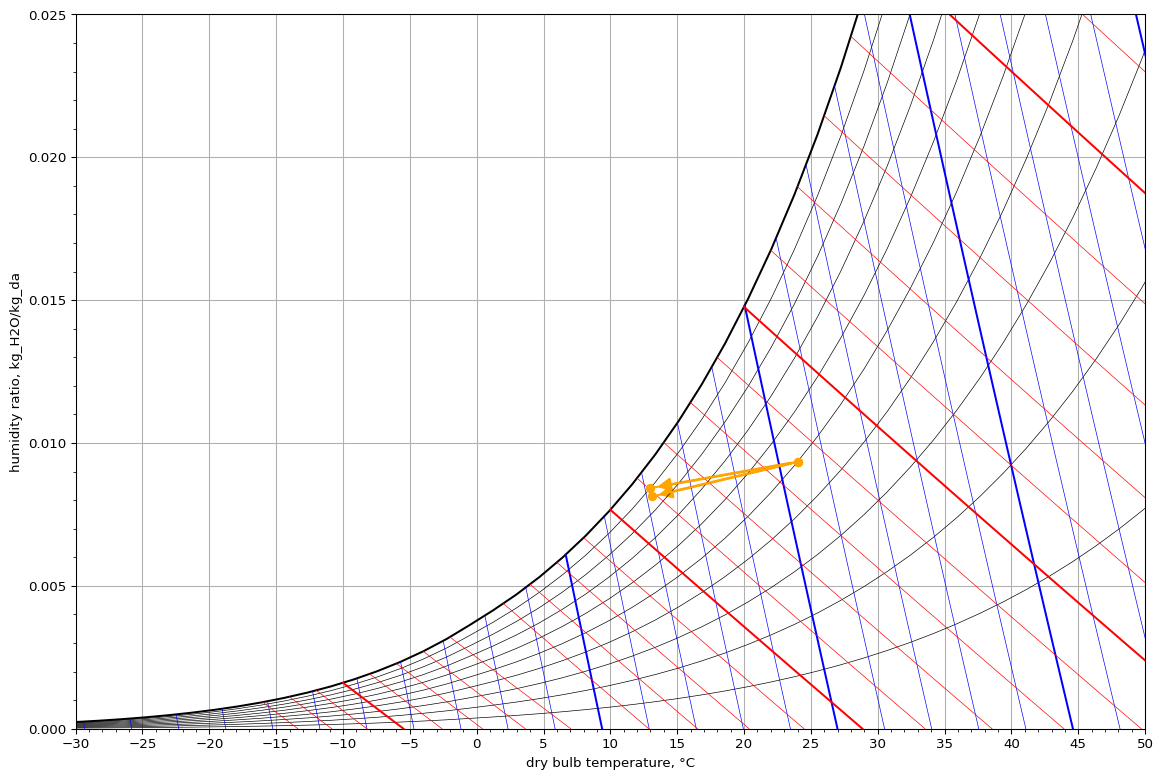

In [11]:
start_point = HumidAir(Tdb=Q_(24, 'degC'), RH=Q_(50, 'pct'))

# According to preliminary calculation:
psy_chart = PsychrometricChart()
psy_chart.plot_process(
    name='pre_calc',
    start_point=start_point,
    end_point=HumidAir(Tdb=Q_(13, 'degC'), RH=Q_(90, 'pct'))
)

# According to evaporator rating:
psy_chart.plot_process(
    name='evap_rating',
    start_point=start_point,
    end_point=evp.air_out
)

psy_chart.show()

## Other Properties about Air Evaporator Performance

To find the "apparatus dew point" (ADP), the contact factor, and the sensible and latent cooling capacity of the evaporator, we can model the air cooling process of the evaporator as an instance of the `AirConditioningProcess` class: 

In [12]:
evp_proc = AirConditioningProcess(
    air_in=evp.air_in,
    air_out=evp.air_out,
    m_da=evp.air_m_dot
)

In [13]:
print(
    f"ADP: {evp_proc.ADP}",
    f"contact factor = {evp_proc.beta.to('pct'):~P.1f}",
    f"sensible cooling capacity = {evp_proc.Q_sen.to('kW'):~P.3f}",
    f"latent cooling capacity = {evp_proc.Q_lat.to('kW'):~P.3f}",
    f"SHR = {evp_proc.SHR.to('pct'):~P.1f}",
    sep='\n'
)

ADP: 10.29 °C DB, 7.81 g/kg AH (100 % RH)
contact factor = 79.3 %
sensible cooling capacity = -4.622 kW
latent cooling capacity = -1.291 kW
SHR = 78.2 %
